In [6]:
import ants
import glob, os


In [18]:
# motion correction & sum 
def motioncorrection(pet_fullpath, subject, session):

    """Do motion correction and sum the PET file and return the fullpath of mc corrected and summed pet image

    Args:
        pet_file (str): fullpath to the unprocessed pet nifti file in native space 
        subject (str): subject id, e.g. sub-tbsfdg002
        session (str): session number: ses-002 or ses-003
    """
    
    import ants, os

    pet_dir = os.path.dirname(pet_fullpath)
    # do first round motion correction 
    pet_image=ants.image_read(pet_fullpath) 
    images_unmerged = ants.ndimage_to_list( pet_image )
    motion_corrected_first = list()
    for i in range(len(images_unmerged)):
        areg = ants.registration( images_unmerged[0], images_unmerged[i], type_of_transform='Affine' )
        motion_corrected_first.append( areg[ 'warpedmovout' ] )   

    # sum the motion corrected to be used as a template
    template= motion_corrected_first[0]
    for i in range(1,len(motion_corrected_first)):
        template + motion_corrected_first[i]
    template_pet_fullpath = f'{pet_dir}/{subject}-{session}_template_pet.nii.gz' 
    ants.image_write(image=template, filename=template_pet_fullpath) 

    # do motion correction but this time use the template
    motion_corrected_second = list()
    for i in range(len(images_unmerged)):
        areg = ants.registration( template, images_unmerged[i], type_of_transform='Affine')
        motion_corrected_second.append( areg[ 'warpedmovout' ] ) 
        
    # save the motion corrected PET   
    mc = ants.list_to_ndimage( pet_image, motion_corrected_second )
    mc_pet_fullpath = f'{pet_dir}/{subject}-{session}_mc_pet.nii.gz' 
    ants.image_write(image=mc, filename=mc_pet_fullpath) 
    
    # sum the motion corrected PET
    sum_mc = motion_corrected_second[0]
    for i in range(1,len(motion_corrected_second)):
        sum_mc  + motion_corrected_second[i]
    sum_mc_pet_fullpath = f'{pet_dir}/{subject}-{session}_sum_mc_pet.nii.gz' 
    ants.image_write(image=sum_mc, filename=sum_mc_pet_fullpath) 
    
    return(sum_mc_pet_fullpath)
    

In [45]:
def register(sum_mc_pet_fullpath, bids_dir, subject, session):
    """Register and write PET image to MNI152 space by combining co-registeration of the PET to T1 and T1 to MNI152

    Args:
        bids_dir (str): derivatives folder 
        subject (str): subject ID
        session (str): session
        pet (str): filename
    Returns:
    Full path to MNI152 registered summed PET image
    """
    
    sum_mc_pet = ants.image_read(sum_mc_pet_fullpath)
    pet_dir = os.path.dirname(sum_mc_pet_fullpath)
    # files
    T1w_file = glob.glob(f'{bids_dir}/{subject}/{session}/anat/*_desc-preproc_T1w.nii.gz')[0]
    T1w_MNI_file = glob.glob(f'{bids_dir}/{subject}/{session}/anat/*_res-2_desc-preproc_T1w.nii.gz')[0]
    T1w_to_MNI_file = glob.glob(f'{bids_dir}/{subject}/{session}/anat/*MNI152NLin6Asym_mode-image_xfm.h5')[0]

    # load as ants images 
    T1w = ants.image_read(T1w_file)
    T1w_MNI = ants.image_read(T1w_MNI_file)
    
    # regdir 
    regdir = f'{pet_dir}/regdir/'
    
    if not os.path.exists(regdir):
        os.makedirs(regdir)

    
    # register PET to T1
    registration = ants.registration(fixed=T1w, 
                                    moving=sum_mc_pet, 
                                    type_of_transform='Affine',
                                    metric='MI', 
                                    outputprefix=regdir)
    
    # combine 1) register PET to T1 and 2) T1w_to_MNI_file into comb_warp
    comb_warp= ants.apply_transforms(fixed=T1w_MNI,
                                    moving=sum_mc_pet,
                                    transformlist=[ T1w_to_MNI_file, registration['fwdtransforms'][0]],
                                    compose=regdir)

    # apply comb_warp to PET to get it in MNI 
    MNI152_sum_mc_pet_fullpath = f'{pet_dir}/{subject}-{session}_MNI152_sum_mc_pet.nii.gz' 
    PET_MNIspace = ants.apply_transforms(fixed=T1w_MNI, moving=sum_mc_pet, transformlist=[comb_warp])
    ants.image_write(image=PET_MNIspace, filename=MNI152_sum_mc_pet_fullpath)
    
    return(MNI152_sum_mc_pet_fullpath)

    
    

'/home/lauri/Documents/TMS-FDG/derivatives/iter6s2/sub-tbsfdg001/ses-002/anat/sub-tbsfdg001_ses-002_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5'

In [54]:
sum_mc_pet = ants.image_read(f'{pet_dir}/{subject}-{session}_sum_mc_pet_2mm.nii.gz' )
pet_dir = os.path.dirname(sum_mc_pet_fullpath)
# files
T1w_file = glob.glob(f'{bids_dir}/{subject}/{session}/anat/*_desc-preproc_T1w.nii.gz')[0]
T1w_MNI_file = glob.glob(f'{bids_dir}/{subject}/{session}/anat/*_res-2_desc-preproc_T1w.nii.gz')[0]
T1w_to_MNI_file = glob.glob(f'{bids_dir}/{subject}/{session}/anat/*MNI152NLin6Asym_mode-image_xfm.h5')[0]
  # load as ants images 
T1w = ants.image_read(T1w_file)
T1w_MNI = ants.image_read(T1w_MNI_file)


# regdir 
regdir = f'{pet_dir}/regdir/'

if not os.path.exists(regdir):
    os.makedirs(regdir)


# register PET to T1
registration = ants.registration(fixed=T1w, 
                              moving=sum_mc_pet, 
                              type_of_transform='Affine',
                              metric='MI', 
                              outputprefix=regdir)

comptx_file = ants.apply_transforms(fixed=T1w_MNI,
                                    moving=sum_mc_pet ,
                                    transformlist=[ T1w_to_MNI_file, registration['fwdtransforms'][0]],
                                    compose=regdir)

PET_MNIspace = ants.apply_transforms(fixed=T1w_MNI,moving=sum_mc_pet ,transformlist=[comptx_file])

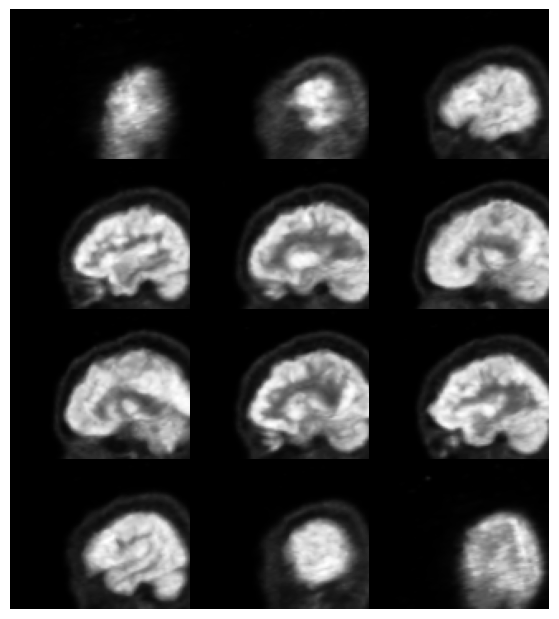

In [55]:
PET_MNIspace.plot()

In [39]:
comb_warp= ants.apply_transforms(fixed=T1w_MNI,
                                moving=sum_mc_pet,
                                transformlist=[ T1w_to_MNI_file, registration['fwdtransforms'][0]])



In [41]:
PET_MNIspace = ants.apply_transforms(fixed=T1w_MNI, moving=sum_mc_pet, transformlist=comb_warp)


TypeError: stat: path should be string, bytes, os.PathLike or integer, not ANTsImage

In [38]:
print(sum_mc_pet_fullpath)
os.path.dirname(sum_mc_pet_fullpath)

/home/lauri/Documents/TMS-FDG/derivatives/iter6s2/sub-tbsfdg001/ses-002/pet/sub-tbsfdg001-ses-002_sum_mc_pet.nii.gz


'/home/lauri/Documents/TMS-FDG/derivatives/iter6s2/sub-tbsfdg001/ses-002/pet'

In [20]:

# directories & files 
bids_dir = '/home/lauri/Documents/TMS-FDG/derivatives/iter6s2'
subject =  'sub-tbsfdg001'
session = 'ses-002'

pet_file = f'{bids_dir}/{subject}/{session}/pet/{subject}-{session}_pet.nii.gz'
sum_mc_pet_fullpath = motioncorrection(pet_file, subject, session)



In [23]:
MNI152_sum_mc_pet_fullpath = register(sum_mc_pet_fullpath, bids_dir, subject, session)


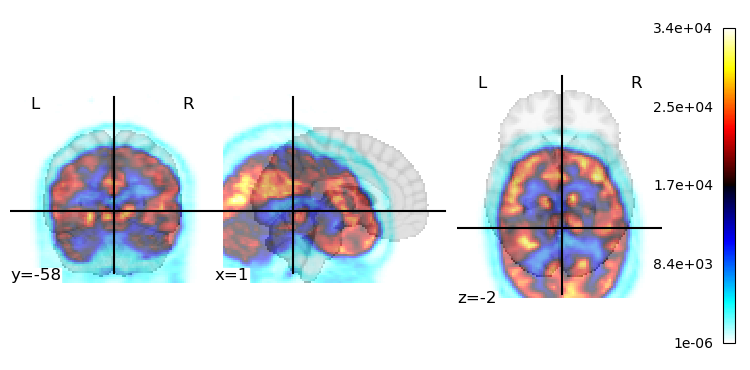

In [27]:
#img= ants.image_read(MNI152_sum_mc_pet_fullpath)
#img.plot()
from nilearn import plotting
plotting.plot_stat_map(MNI152_sum_mc_pet_fullpath, alpha= 2/4)

In [16]:
# calculate SUVR
# 1. get GM & WM maps 
# 2. binarize & add them together
# 3. extract ref-value from MNI152_sum_mc_pet.nii.gz 
# 4. store ref-value to a text file 
# 5. divide MNI152_sum_mc_pet.nii.gz by ref-value


wm = f'{bids_dir}/{subject}/{session}/anat/{subject}-{session}sub-tbsfdg001_ses-002_space-MNI152NLin6Asym_res-2_label-GM_probseg.nii.gz
sub-tbsfdg001_ses-002_space-MNI152NLin6Asym_res-2_label-WM_probseg.nii.gz


True